<a href="https://colab.research.google.com/github/break-pointt/camera_calibration/blob/master/TSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [ ]:
!git clone https://github.com/ultralytics/yolov3  # clone repo
%cd yolov3
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
%cd ..

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
/content


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install openimages
!pip install albumentations

In [ ]:
import cv2
import csv
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,AvgPool2D,Dense
from openimages.download import download_dataset
import albumentations as A

In [ ]:
#system variables
!rm -rf /content/sample_data
dataset_dir = '/content/dataset'
csv_dir = '/content/csv'
classes = ['Traffic sign']
label_format = ['darknet','pascal']

In [ ]:
if not os.path.exists(dataset_dir):
    download_dataset(dest_dir=dataset_dir,class_labels=classes,annotation_format=label_format[0],csv_dir=csv_dir,limit=5000)

2021-01-07  05:50:18 INFO NumExpr defaulting to 2 threads.
2021-01-07  05:50:20 INFO Downloading 2514 train images for class 'traffic sign'
100%|██████████| 2514/2514 [00:25<00:00, 96.81it/s]
2021-01-07  05:50:46 INFO Creating 2514 train annotations (darknet) for class 'traffic sign'
100%|██████████| 2514/2514 [00:00<00:00, 2668.20it/s]
2021-01-07  05:50:50 INFO Downloading 16 validation images for class 'traffic sign'
100%|██████████| 16/16 [00:00<00:00, 58.27it/s]
2021-01-07  05:50:50 INFO Creating 16 validation annotations (darknet) for class 'traffic sign'
100%|██████████| 16/16 [00:00<00:00, 570.74it/s]
2021-01-07  05:50:52 INFO Downloading 40 test images for class 'traffic sign'
100%|██████████| 40/40 [00:00<00:00, 84.07it/s]
2021-01-07  05:50:53 INFO Creating 40 test annotations (darknet) for class 'traffic sign'
100%|██████████| 40/40 [00:00<00:00, 1089.79it/s]


In [ ]:
!mv '/content/dataset/traffic sign' '/content/dataset/trafficSign'
!mv '/content/dataset/trafficSign/darknet' '/content/dataset/trafficSign/labels'

In [ ]:
if not os.path.exists('/content/GTSDB_train.zip'):
    !cp '/content/gdrive/MyDrive/Colab Notebooks/work/dataset/GTSDB/train.zip' '/content/GTSDB_train.zip'

if not os.path.exists('/content/train.yaml'):
    !cp '/content/gdrive/MyDrive/Colab Notebooks/work/dataset/GTSDB/train.yaml' '/content/train.yaml'

In [ ]:
%%capture
!unzip '/content/GTSDB_train.zip'

In [ ]:
if not os.path.exists('/content/GTSDB_train'):
    !mv '/content/TrainIJCNN2013' '/content/GTSDB_train'
else:
    !rm -rf '/content/GTSDB_train'
    !mv '/content/TrainIJCNN2013' '/content/GTSDB_train'

In [ ]:
labelPath = '/content/GTSDB_train/gt.txt'
annotationfile = '/content/trainLabels.txt'
with open(annotationfile, 'w') as a:
    with open(labelPath, 'r') as f:
        reader = csv.reader(f, delimiter=";")
        fileName = ""
        firstEntry = True
        for entry in reader:
            if entry[0] == fileName:
                x1, y1, x2, y2 = entry[1:5]
                a.write(' %s;%s;%s;%s' % (x1, y1, x2, y2))
            else:
                fileName = entry[0]
                if firstEntry:
                    firstEntry = False
                else:
                    a.write('\n')
                a.write('/content/GTSDB_train/%s '%(fileName))
                x1, y1, x2, y2 = entry[1:5]
                a.write('%s;%s;%s;%s' % (x1, y1, x2, y2))

In [ ]:
!mkdir -p '/content/data/train/images'
!mkdir -p  '/content/data/train/labels'

In [ ]:
saveDir = "/content/data/train"
with open(annotationfile, 'r') as a:
    reader = csv.reader(a, delimiter=" ")
    for entry in reader:
        imagePath = entry[0]
        fileName = os.path.split(imagePath)[-1].split('.')[0]
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        cv2.imwrite('%s/images/%s.jpg'%(saveDir,fileName),image)
        n,m = image.shape[0:2]
        boxes = entry[1:]
        with open('%s/labels/%s.txt'%(saveDir,fileName),'w') as b:
            firstEntry = True
            for box in boxes:
                x1,y1,x2,y2 = map(int,box.split(';'))
                x = (x1 + x2) / 2 / m
                y = (y1 + y2) / 2 / n
                w = (x2 - x1) / m
                h = (y2 - y1) / n

                if firstEntry:
                    firstEntry = False
                else:
                    b.write('\n')
                
                b.write('0 %s %s %s %s'%(x,y,w,h))

In [ ]:
!cp -a '/content/dataset/trafficSign/images/.' '/content/data/train/images/'
!cp -a '/content/dataset/trafficSign/labels/.' '/content/data/train/labels/'

In [ ]:
# def randomSplitDataFromDir(dirpath,test_ratio):
#     """
#     This function takes a Directory path, test split ratio and create 2 files
#     in the root directory.
#     """
#     files = np.array(os.listdir(dirpath))
#     msk = np.random.rand(len(files)) < (1-test_ratio)
#     train = files[msk]
#     test = files[~msk]
#     print(train.shape,test.shape)
#     with open('/content/train.txt','w') as trainFile:
#         firstFile = True
#         for file in train:
#             if firstFile:
#                 trainFile.write('%s/%s'%(dirpath,file))
#                 firstFile = False
#             else:
#                 trainFile.write('\n%s/%s'%(dirpath,file))

#     with open('/content/test.txt','w') as testFile:
#         firstFile = True
#         for file in test:
#             if firstFile:
#                 testFile.write('%s/%s'%(dirpath,file))
#                 firstFile = False
#             else:
#                 testFile.write('\n%s/%s'%(dirpath,file))

In [ ]:
# randomSplitDataFromDir('/content/dataset/trafficSign/images',0.2)

In [ ]:
#  with open('/content/labelNames.names','w') as labelFile:
#      labelFile.write('trafficSign')

In [ ]:
# with open('/content/traffic.data','w') as dataFile:
#     dataFile.write('classes=1'+'\n')
#     dataFile.write('train=/content/train.txt'+'\n')
#     dataFile.write('valid=/content/test.txt'+'\n')
#     dataFile.write('names=/content/labelNames.names'+'\n')
#     dataFile.write('backup=backup/'+'\n')
#     dataFile.write('eval=coco')

In [ ]:
%cd yolov3/

/content/yolov3


In [ ]:
# !python3 train.py --img 640 --batch 16 --epochs 200 --data '/content/train.yaml'

In [ ]:
# !rm -rf /content/yolov3/runs/detect/*

In [ ]:
weightsPath = '/content/gdrive/MyDrive/Colab Notebooks/work/weights/traffic_best.pt'
testImagesDir = '/content/gdrive/MyDrive/Colab Notebooks/work/test_images'

In [ ]:
!python detect.py --weights "/content/gdrive/MyDrive/Colab Notebooks/work/weights/traffic_best.pt" --img 640 --conf 0.25 --source "/content/gdrive/MyDrive/Colab Notebooks/work/test_images"

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/gdrive/MyDrive/Colab Notebooks/work/test_images', update=False, view_img=False, weights=['/content/gdrive/MyDrive/Colab Notebooks/work/weights/traffic_best.pt'])
Using torch 1.7.0+cu101 CUDA:0 (Tesla T4, 15079.75MB)


Fusing layers... 
Model Summary: 261 layers, 61497430 parameters, 0 gradients, 154.9 GFLOPS
image 1/4 /content/gdrive/MyDrive/Colab Notebooks/work/test_images/test_image01.png: 416x640 2 TrafficSigns, Done. (0.054s)
image 2/4 /content/gdrive/MyDrive/Colab Notebooks/work/test_images/test_image04.jpg: 480x640 10 TrafficSigns, Done. (0.027s)
image 3/4 /content/gdrive/MyDrive/Colab Notebooks/work/test_images/test_image2.jpg: 480x640 32 TrafficSigns, Done. (0.026s)
image 4/4 /content/gdrive/MyDrive/Colab Notebooks/work/test_images/test_image3.jpg: 480x640 2 Traff

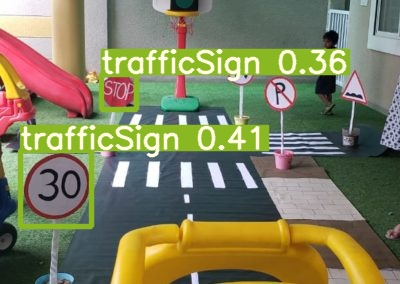

In [ ]:
# Image(filename='/content/yolov3/runs/detect/exp/testImage2.jpg', width=600)

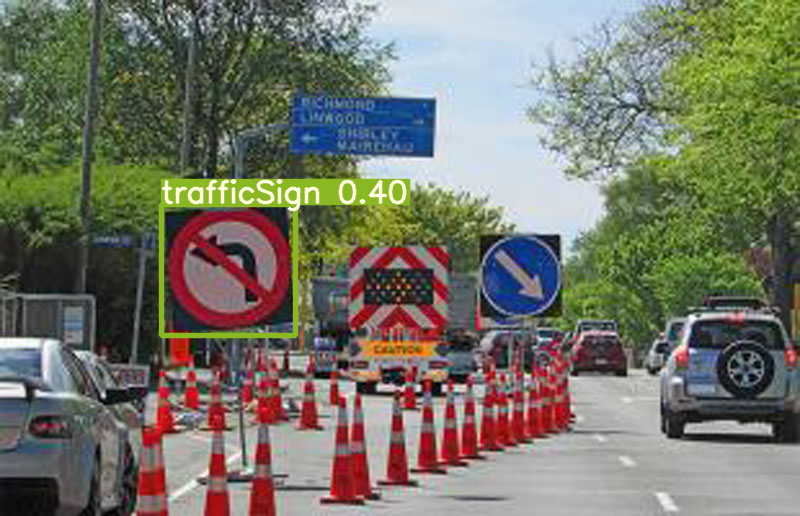

In [ ]:
# Image(filename='/content/yolov3/runs/detect/exp/testImage1.png', width=600)

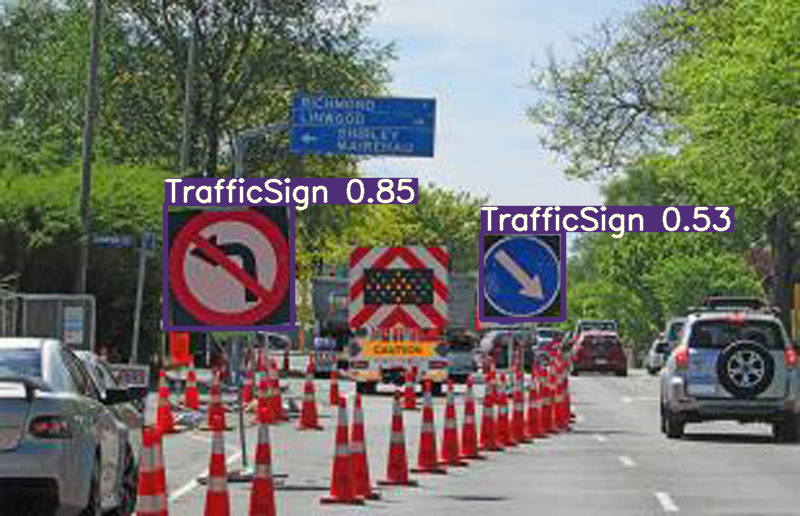

In [ ]:
Image(filename='/content/yolov3/runs/detect/exp/test_image01.png', width=600)

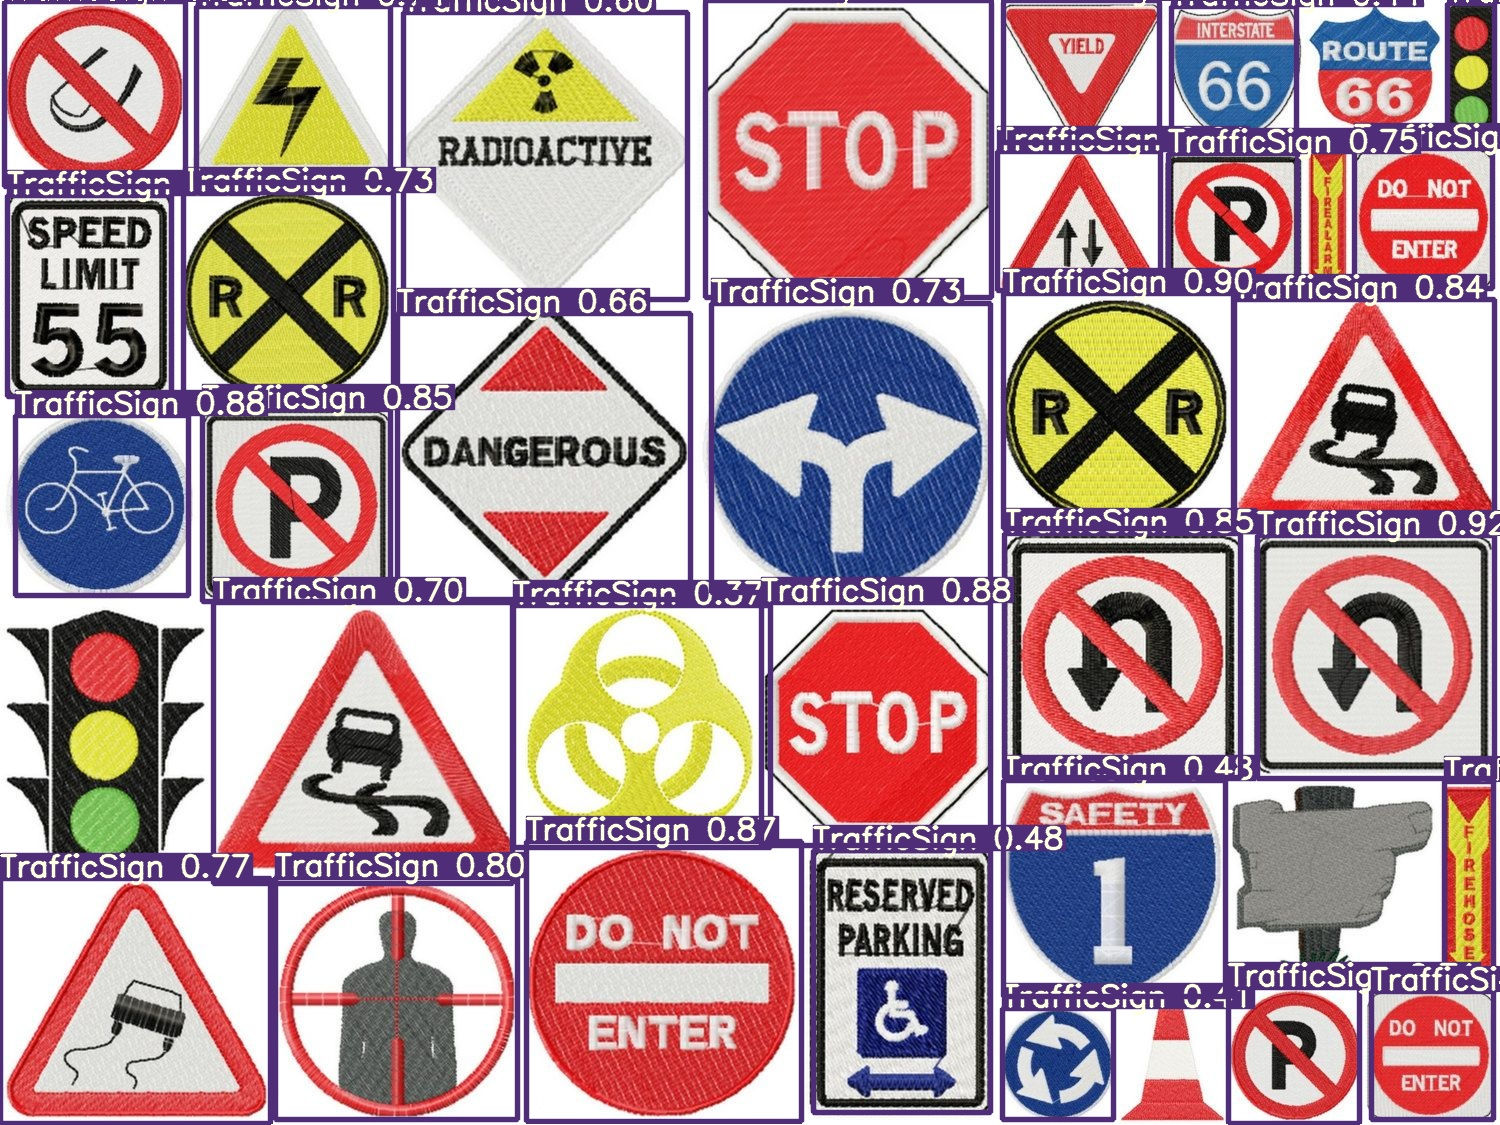

In [ ]:
Image(filename='/content/yolov3/runs/detect/exp/test_image2.jpg', width=600)

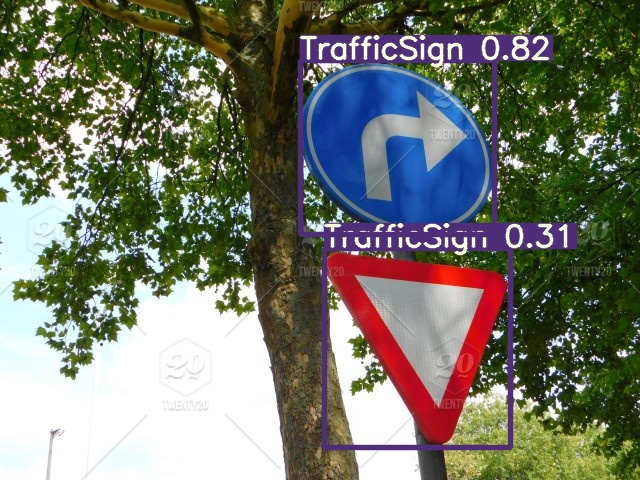

In [ ]:
Image(filename='/content/yolov3/runs/detect/exp/test_image3.jpg', width=600)

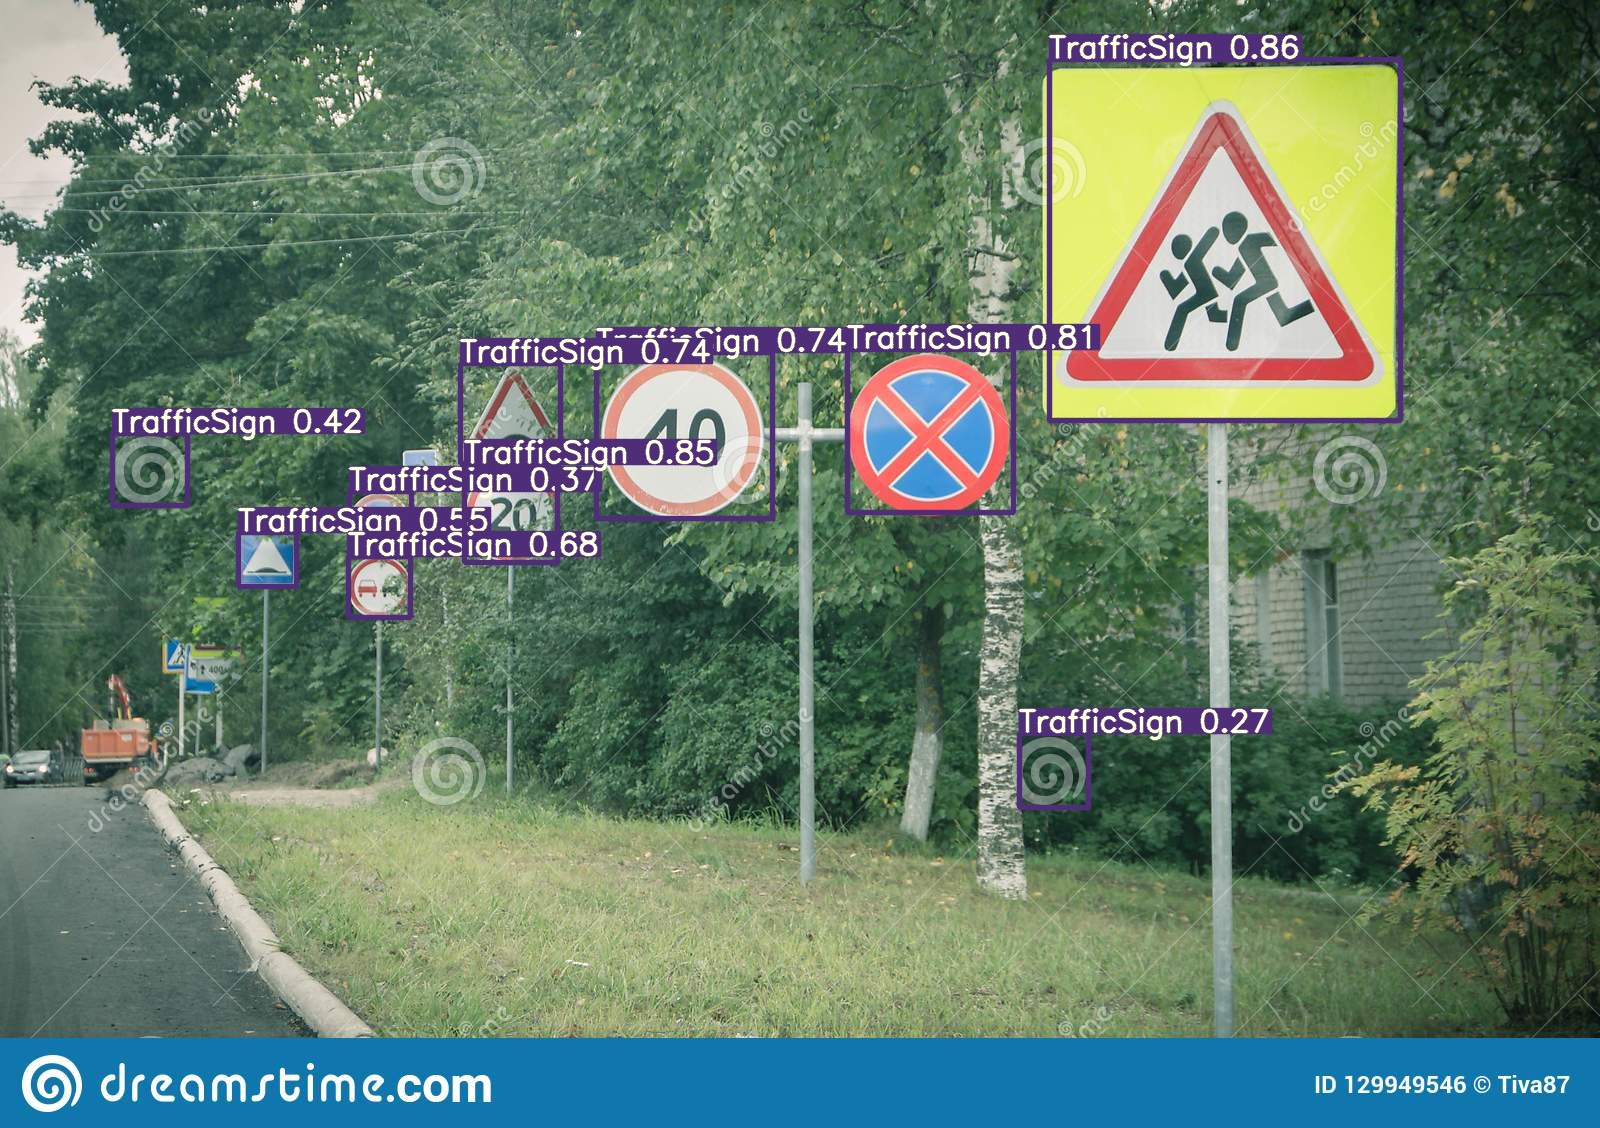

In [ ]:
Image(filename='/content/yolov3/runs/detect/exp/test_image04.jpg', width=600)

In [ ]:
!cp '/content/yolov3/runs/train/exp/weights/best.pt' '/content/gdrive/MyDrive/Colab Notebooks/work/weights/traffic_best.pt'